In [529]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

def score_dataset(X, y, model=XGBClassifier()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=10, scoring="recall",
    )
    return score.mean()

def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

## Preprocessing

In [478]:
cwd= os.getcwd()
df=pd.read_csv(cwd+"\\credit_rating.csv")
df.head(5)

,Unnamed: 0,checking,duration,credithistory,creditamount,savings,employment,installmentrate,guarantors,residence,...,d$purpose_A42,d$purpose_A43,d$purpose_A44,d$purpose_A45,d$purpose_A46,d$purpose_A48,d$purpose_A49,nmac,male,married
0,1,1.0,6.0,0.0,1169.0,0.0,4.0,4.0,0.0,4.0,...,0,1,0,0,0,0,0,0,1,0
1,2,2.0,48.0,2.0,5951.0,0.0,2.0,2.0,0.0,2.0,...,0,1,0,0,0,0,0,1,0,1
2,3,0.0,12.0,0.0,2096.0,0.0,3.0,2.0,0.0,3.0,...,0,0,0,0,1,0,0,1,1,0
3,4,1.0,42.0,2.0,7882.0,0.0,3.0,2.0,1.0,4.0,...,1,0,0,0,0,0,0,1,1,0
4,5,1.0,24.0,1.0,4870.0,0.0,2.0,3.0,0.0,4.0,...,0,0,0,0,0,0,0,1,1,0


In [479]:
df.drop(['Unnamed: 0', 'd$purpose_A40', 'd$purpose_A41', 'd$purpose_A42',
       'd$purpose_A43', 'd$purpose_A44', 'd$purpose_A45', 'd$purpose_A46',
       'd$purpose_A48', 'd$purpose_A49'], axis=1, inplace=True)
df = df.dropna()

In [480]:
df.describe().T["std"].sort_values(ascending=False)

creditamount          2822.736876
duration                12.058814
age                     11.375469
employment               1.208306
installmentrate          1.118715
residence                1.103718
credithistory            1.083120
property                 1.050209
checking                 0.957034
savings                  0.805307
job                      0.653614
numexistingcredits       0.577654
married                  0.497940
male                     0.462725
creditrating             0.458487
nmac                     0.386860
housing                  0.383544
guarantors               0.290578
foreigner                0.188856
Name: std, dtype: float64

C:\Users\daisu\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\daisu\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\daisu\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:>

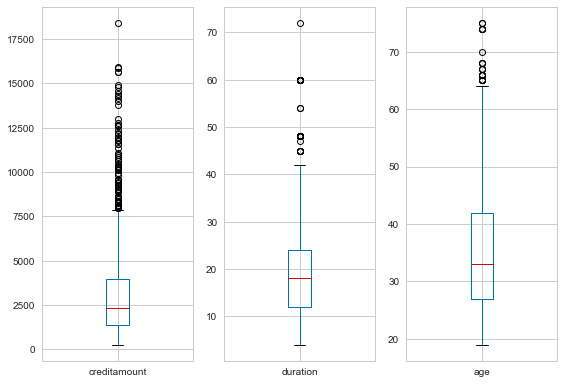

In [481]:
fig, ax = plt.subplots(1,3)
df.creditamount.plot.box(ax=ax[0])
df.duration.plot.box(ax=ax[1])
df.age.plot.box(ax=ax[2])

<AxesSubplot:xlabel='age', ylabel='Density'>

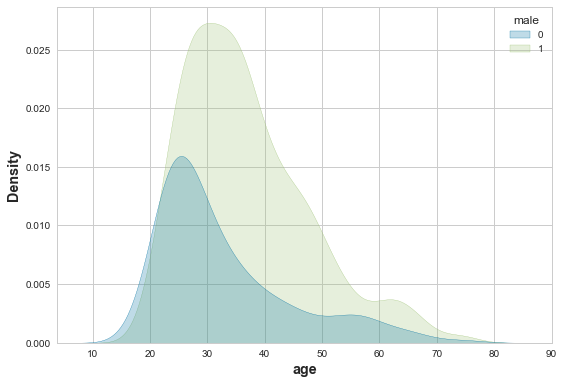

In [482]:
sns.kdeplot(df.age, shade=True, hue=df.male)

## Clustering

### K-Means

In [483]:
y, X = df.pop("creditrating"), df
X_scaled=(X - X.mean(axis=0))/X.std(axis=0)

**Inertia** is the mean squared distance between each instance and its closest centroid

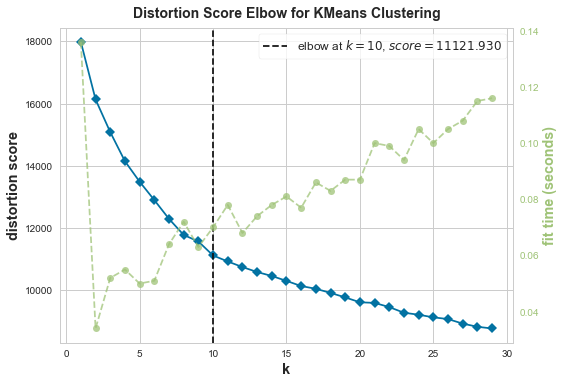

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [484]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,30))
visualizer.fit(X_scaled)
visualizer.show()

$\text{silhouette_score} = \frac{(b-a)}{max(a,b)}$

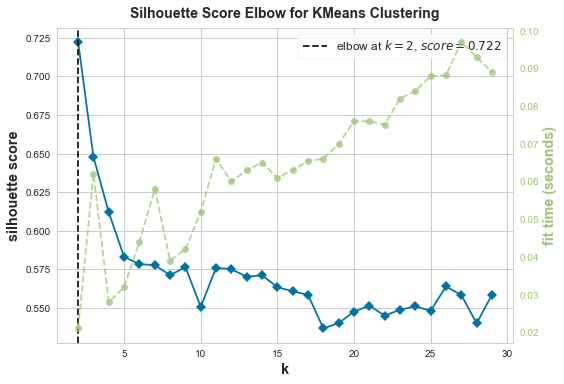

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [485]:
visualizer = KElbowVisualizer(kmeans, k=(2,30), metric="silhouette")
visualizer.fit(X)
visualizer.show()

In [486]:
kmeans = KMeans(n_clusters=9)
X["Cluster"] = kmeans.fit_predict(X_scaled)
X["Cluster"] = X["Cluster"].astype("category")
X.head()

from sklearn.metrics import silhouette_score
silhouette_score(X_scaled, kmeans.labels_)

0.10370315885828442

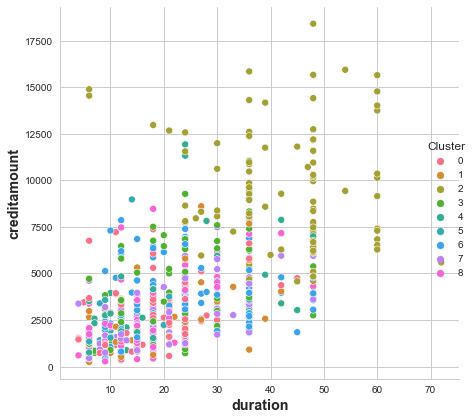

In [487]:
sns.relplot(
    x="duration", y="creditamount", hue="Cluster", data=X, height=6,
);

In [488]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=0)
X_cd=kmeans.fit_transform(X_scaled)

Add centroids to the original dataset

In [489]:
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X = X.join(X_cd)

## Prediction without Cluster-Distance Features

In [490]:
score_dataset(df, y)

C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of lab

[19:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of lab

[19:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of lab

[19:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:42:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8642857142857142

## Prediction with Cluster-Distance Features

In [491]:
import sklearn
pd.DataFrame(sorted(sklearn.metrics.SCORERS.keys()), columns=["Metrics"])

score_dataset(X, y)

C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:42:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\daisu\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.8714285714285713

## DBSCAN

This method is sensitive to the dimensionality(i.e. [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)) \
Clustering result shows `-1` which means all observations are outliers

In [492]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=0.05, min_samples=10).fit(X)
dbscan.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

## Principal Component Analysis

In [493]:
_, X=df.pop("Cluster"), df

In [494]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,2.032307,-3.271736,-0.930733,0.506708,1.541232,-1.170940,-0.471635,-1.023304,0.360792,0.053358,-0.029694,-0.908071,1.328994,-0.613269,0.370322,-0.137041,0.285807,0.010534
1,-1.330358,2.568534,0.288096,0.599256,-0.904404,-0.237146,0.059694,-0.644963,0.407444,-0.885653,0.900114,-1.084985,-0.616704,-1.331077,-0.849765,0.178256,-0.293594,-0.737374
2,0.322098,-2.185407,0.467993,0.589244,0.136258,0.157628,-1.205714,-0.224479,-0.065698,-1.107821,-0.828115,0.281326,-0.429367,-0.682416,-0.879419,-1.320100,0.147560,-0.158537
3,1.721940,1.286649,1.151377,1.210902,1.341643,1.543908,1.592298,-0.280716,1.136721,-2.121756,-0.728131,0.246561,0.085906,-0.245122,-0.634555,0.006832,-0.149396,-0.202108
4,2.211287,-0.150288,-0.553861,0.237408,-0.172611,0.525674,-0.012656,-1.090346,-0.195145,0.632689,-0.400701,1.506208,0.106434,0.046267,0.226198,-0.010680,-0.024682,0.014157


These new features are called the **principal components** of the data. \
The weights themselves are called **loadings**.

In [495]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
checking,-0.096645,0.160007,0.214766,-0.055267,0.079191,0.199230,0.205498,-0.659113,-0.185894,0.342411,0.211767,-0.404006,0.157087,0.043832,-0.068031,-0.006561,0.039606,-0.023442
duration,0.289848,0.440102,-0.030772,0.061129,-0.106228,0.023094,0.144436,0.025877,-0.001795,-0.288446,0.437071,0.021785,-0.067290,-0.223064,-0.072197,-0.084246,-0.487138,-0.325050
credithistory,-0.150479,0.331777,0.237761,-0.327885,0.364010,0.098067,-0.152168,-0.002837,0.022633,-0.109917,-0.047031,0.104335,-0.134136,-0.144493,0.453925,0.516983,-0.006867,-0.005407
creditamount,0.287535,0.468608,0.000714,0.322825,-0.100338,0.155450,-0.076087,0.022462,0.057647,-0.133397,0.066905,-0.013568,0.055057,-0.152607,0.004830,-0.036460,0.570087,0.417776
savings,-0.044004,-0.095574,-0.124825,-0.329138,-0.292000,0.530375,-0.185326,0.220915,0.108686,-0.186469,0.256141,-0.192302,0.407547,0.292890,0.063298,0.098745,0.020263,-0.009359
employment,0.298098,-0.199476,-0.193162,-0.115213,0.226388,0.130400,0.044190,0.074828,0.140598,-0.092836,0.022665,-0.596599,-0.583820,0.019882,0.093037,-0.069980,0.053894,0.049242
installmentrate,0.115537,-0.155684,-0.059157,-0.496518,0.054112,-0.337227,0.455784,0.093798,0.011041,0.049576,0.436518,0.167093,0.117246,-0.153044,0.073643,-0.048901,0.263363,0.209293
guarantors,-0.059623,-0.016219,0.232874,0.241259,0.227291,0.156236,0.654854,0.042224,0.304536,-0.341153,-0.175938,0.037970,0.125360,0.341597,0.046270,0.019864,-0.023645,0.006034
residence,0.161135,-0.076506,-0.441509,0.003575,0.447416,0.280809,0.043476,-0.079229,-0.136745,0.004505,-0.007401,0.238323,0.079856,-0.062468,-0.517503,0.361438,-0.013235,0.039529
property,-0.279435,-0.303906,0.179979,0.164935,0.023319,-0.058148,-0.007149,0.077269,-0.009519,-0.349752,0.036594,-0.352292,0.225136,-0.632970,-0.166506,0.157136,0.076624,-0.050242


Look at the MI scores of the components

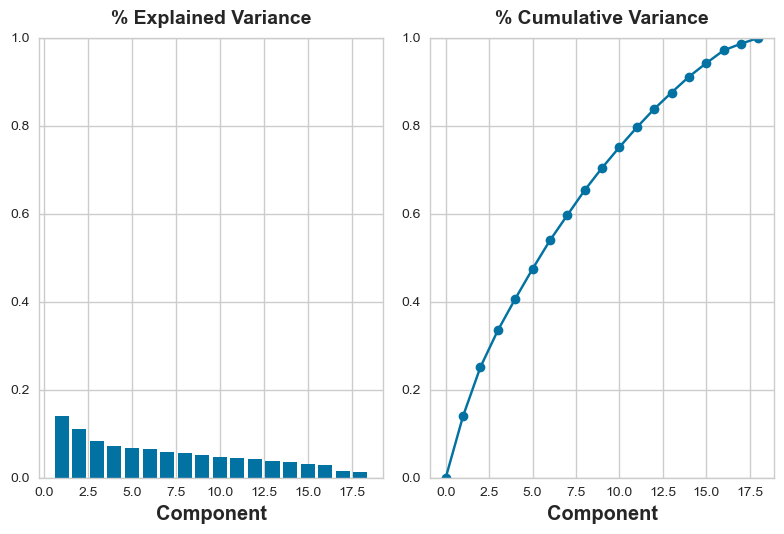

In [496]:
# Look at explained variance
plot_variance(pca);

In [497]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC2     0.052333
PC17    0.024649
PC11    0.020219
PC7     0.019149
PC13    0.016655
PC6     0.014629
PC18    0.012474
PC9     0.012019
PC16    0.005724
PC8     0.005715
PC10    0.002722
PC15    0.002129
PC4     0.001332
PC12    0.000000
PC5     0.000000
PC14    0.000000
PC3     0.000000
PC1     0.000000
Name: MI Scores, dtype: float64

In [498]:
# Show dataframe sorted by PC3
idx = X_pca["PC2"].sort_values(ascending=False).index
cols = ["creditamount", "duration", "numexistingcredits", "property"]
df.loc[idx, :]

,checking,duration,credithistory,creditamount,savings,employment,installmentrate,guarantors,residence,property,age,housing,numexistingcredits,job,foreigner,nmac,male,married
915,2.0,48.0,4.0,18424.0,0.0,2.0,1.0,0.0,2.0,2.0,32.0,1.0,0.0,3.0,0.0,1,0,1
95,2.0,54.0,4.0,15945.0,0.0,1.0,3.0,0.0,4.0,0.0,58.0,0.0,0.0,2.0,1.0,1,1,0
63,2.0,48.0,4.0,14421.0,0.0,2.0,2.0,0.0,2.0,1.0,25.0,1.0,0.0,2.0,1.0,1,1,0
714,2.0,60.0,2.0,14027.0,0.0,3.0,4.0,0.0,2.0,0.0,27.0,1.0,0.0,3.0,1.0,1,1,0
272,2.0,48.0,3.0,12169.0,0.0,0.0,4.0,1.0,4.0,0.0,36.0,1.0,0.0,3.0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,0.0,12.0,0.0,1255.0,0.0,4.0,4.0,0.0,4.0,3.0,61.0,1.0,1.0,1.0,1.0,1,1,0
156,1.0,9.0,0.0,1288.0,1.0,4.0,3.0,1.0,4.0,3.0,48.0,1.0,1.0,2.0,0.0,1,1,0
264,0.0,10.0,0.0,1231.0,0.0,4.0,3.0,0.0,4.0,3.0,32.0,1.0,1.0,1.0,0.0,1,1,0
807,0.0,12.0,0.0,930.0,0.0,4.0,4.0,0.0,4.0,3.0,65.0,1.0,3.0,2.0,1.0,0,1,0


## Anomaly Detection

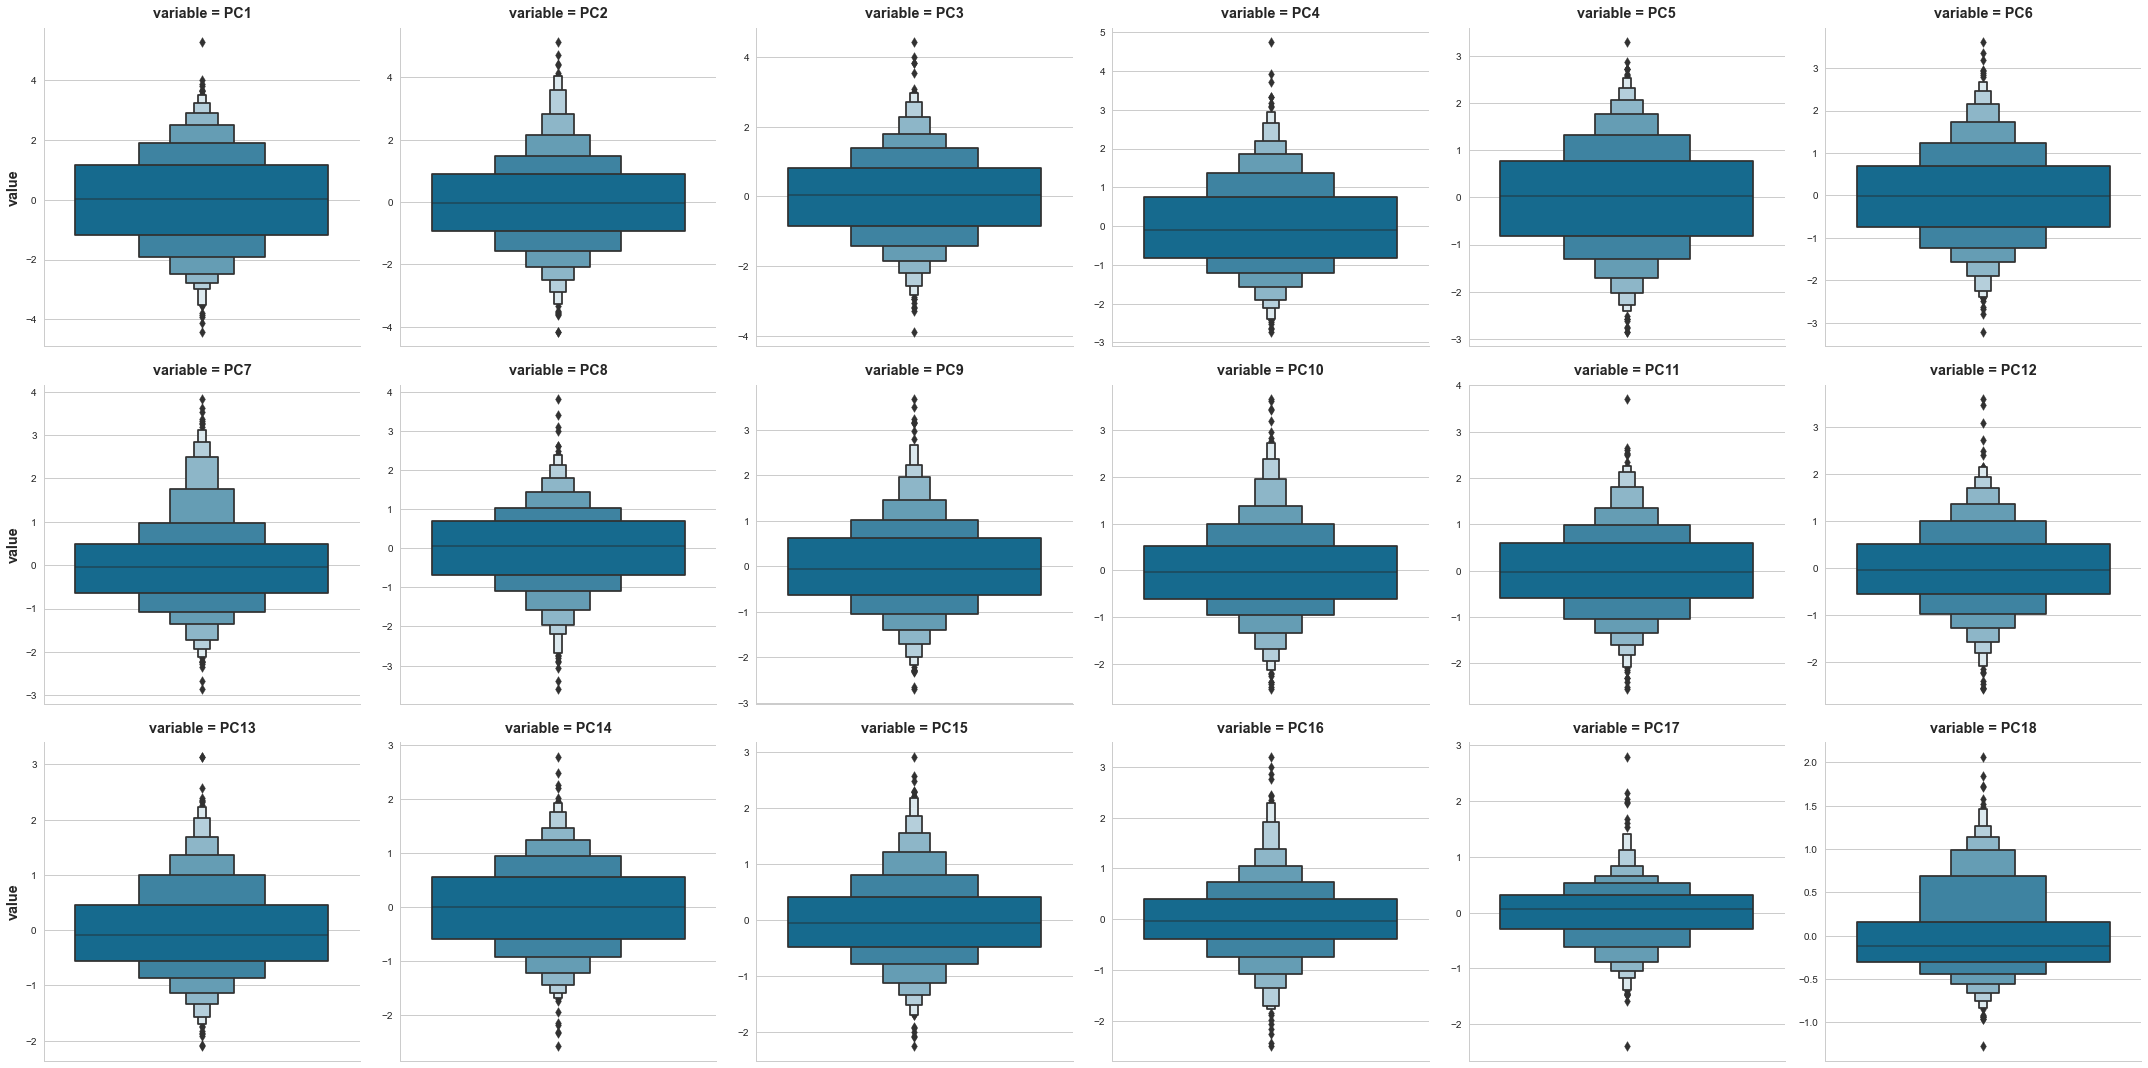

In [500]:
sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=6,
);

In [506]:
# You can change PC1 to PC2, PC3, or PC4
component = "PC1"

idx = X_pca[component].sort_values(ascending=False).index
df.loc[idx, :].loc[1,:]

checking                 2.000000
duration                48.000000
credithistory            2.000000
creditamount          5951.000000
savings                  0.000000
employment               2.000000
installmentrate          2.000000
guarantors               0.000000
residence                2.000000
property                 3.000000
age                     22.000000
housing                  1.000000
numexistingcredits       0.000000
job                      2.000000
foreigner                1.000000
nmac                     1.000000
male                     0.000000
married                  1.000000
credit_or_property    1983.666667
Name: 1, dtype: float64

## Model Training

### Random Forest

In [546]:
score_dataset(X.iloc[:, :-1],y, RandomForestClassifier())

C:\Users\daisu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\daisu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\daisu\anaconda3\lib\site-packages\skl

0.8971428571428571

In [545]:
# automatic nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# configure the cross-validation procedure
cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
# define the model
model = RandomForestClassifier(random_state=1)
# define search space
space = dict()
space['n_estimators'] = [10, 100, 500]
space['max_features'] = [2, 4, 6]
# define search
search = GridSearchCV(model, space, scoring='accuracy',  cv=cv_inner)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, X.iloc[:, :-1], y, scoring='recall', cv=cv_outer)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.905 (0.030)


### Logistic Regression

In [547]:
score_dataset(X.iloc[:, :-1],y, LogisticRegression())

C:\Users\daisu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\daisu\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
C:\Users\daisu\anaconda3\lib\site-packages\skl

0.8971428571428571

### Neural Network

In [543]:
score_dataset(X.iloc[:, :-1],y,MLPClassifier(hidden_layer_sizes=(15,),))

0.6028571428571429